# TP avec méthodes de Monte Carlo

[OpenAI gym](https://gym.openai.com/) est un environnement pour tester et comparer des algorithmes d'apprentissage par renforcement. 


## Black Jack (simplifié)

On considère une version simplifiée du jeu de Blackjack où le but est d'accumuler des cartes dont la somme des points ne doit pas dépasser 21. Les figures valent 10 points, les cartes numérotées valent le numéro de la carte. Il y a une complication avec l'as qui peut être vue comme valant 1 point (comme un 1) ou comme un 11 (un as). Ici, on va jouer contre un croupier qui a une stratégie fixée.
* au départ du jeu, le croupier et le joueur possèdent deux cartes. Le joueur peut observer ses deux cartes, mais ne peut observer qu'une seule carte du croupier.
* Si le joueur a déjà 21 points, la partie s'arrête et soit le joueur gagne, soit le match est nul si le croupier a aussi 21 points. 
* si le joueur n'a pas 21 points, il peut décider de rester (stick 0) ou bien il peut demander une nouvelle carte (hit 1) de façon répétée.
* quand le joueur décide de s'arrêter, le dealer peut à son tour s'arrêter ou demander des nouvelles cartes. Ici, on va supposer que ce choix se fait selon une stratégie fixe: il s'arrête dès qu'il a 17 point ou plus, il demande une carte dans le cas contraire.
* si un joueur dépasse 21 points en demandant une carte, il perd la partie
* si les deux joueurs se sont arrêtés, c'est celui dont la somme des cartes est plus proche de 21 qui remporte la partie.

On fait l'hypothèse que le croupier tire les cartes dans une pile infinie (avec remplacement).

Si le joueur possède un as qu'il peut utiliser comme 1 ou 11 sans dépasser 21, on dit qu'il a un as utilisable.

L'état du jeu peut être décrit par un triplet:
* la somme de points courante (dont on pourrait restreindre l'intervalle à [12-21])
* la valeur de la carte du croupier
* la possession ou non d'un as utilisable

On va donc modéliser avec un taux d'escompte $\gamma=1$.

In [35]:
# Import useful modules
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm import tqdm 
from collections import defaultdict

# Set up openAi Gym
import gym
from gym import envs
#env = gym.make("Blackjack-v0") # env not found
env = gym.make("Blackjack-v0")
numActions = env.action_space.n
print(env.observation_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))


In [36]:
env.reset()
env.action_space

Discrete(2)

In [37]:
env.reset()

(6, 7, False)

In [38]:
env.step(1)

((16, 7, False), 0.0, False, {})

In [39]:
env.step(0)

((16, 7, False), -1.0, True, {})

L'état du jeu de blackjack est donc décrit par un triplet $(s_1, s_2, a)$ où $s_1$ est la somme des points contenus dans la main du joueur, $s_2$ est la valeur de la carte visible du croupier, et $a$ est un booléen qui indique si le joueur possède un as utilisable.

Comme vous pouvez le voir dans l'exécution du code ci-dessus, l'espace des états pour ce jeu est encodé comme un triplet, et $s_1$ peut prendre 32 valeurs, $s_2$ peut prendre 11 valeurs. En théorie, on pourrait restreindre $s_1$ a 21 valeurs (au delà de 21 points, on est dans un état final perdant), voir même moins (au deça de 10 points, prendre une carte est sans risque!). Pour faciliter le code, on ne va pas chercher à optimiser l'espace et on va conserver 32 possibilités. 

In [40]:
# maxSum is the maximum sum I can have in my hand
maxSum = 32
# maxOppScore is the maximum value of the card I can see from the opponent
maxOppScore = 11
# number of States
numStates = 32*11*2
print(f'Problem with {numStates} states and {numActions} actions.')

Problem with 704 states and 2 actions.


Pour essayer d'écrire un code que l'on pourra utiliser pour d'autres problèmes, on vous donne le code pour encoder l'état avec un entier et pour faire l'inverse (i.e. décoder un entier en un état). Ainsi, il vous sera possible d'avoir des tables du style $v(s)$ et $q(s,a)$ où $s$ sera l'index d'un des états du jeu, et $a$ l'index d'une action.

In [41]:
# function to encode or decode a state
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# encode a state as an integer
# for blackjack, the state is s=[i,j,b] where
# i is the number of points in my hand i \in [1,31]
# j is the number of points I can observe from the opponent j\in [1,10]
# b is a boolean telling whether I have a usable ace
#
# encode turns the state to an integer, and decode does the opposite
def encode(state):
    if state[2]:
        return state[0] + state[1]*maxSum
    else:
        return state[0] + state[1]*maxSum + maxSum*maxOppScore

def decode(index):
    state = [0, 0, 0]
    if (index > maxSum*maxOppScore):
        state[2] = False
        index = index - maxSum*maxOppScore
    else:
        state[2] = True
        state[0] = index % maxSum
        state[1]= index // maxSum
    return state

## Evaluation d'une politique fixée

On va tout d'abord évaluer une politique fixée $\pi$ avec un algorithme de Monte Carlo. La politique que l'on va évaluer est simple: si le joueur à 20 points ou plus, il s'arrête, sinon, il demande une carte. La politique est encodée dans la fonction strategy ci-dessous.

In [42]:
def strategy(state) :
    if (state[0] >= 20) :
        return 0
    else:
        return 1

### Implémentez

Implémentez l'algorithme de Monte Carlo dans sa version "all-visit" pour évaluer une politique (même si un état se répète plusieurs fois sur la trace d'exécution de l'épisode, on met à jour ses statistiques). Cet algorithme est un peu plus simple à implémenter que son variant "first-visit" pour lequel on met à jour un état seulement lors de sa première visite.

Cela dit, dans le cadre de Blackjack, est-ce qu'on aurait une différence ?

$G_t = \sum_{k=1}^{T}\gamma^{k-1}R_{t+k}$

In [43]:
# Helper function
def generate_episode(env, policy, max_timesteps=100):
    episode = []
    state = env.reset()

    for t in range(max_timesteps):
        action = policy(state) # Choose action following policy pi
        new_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = new_state
        if done:
            #print("Episode finished after {} timesteps".format(t+1))
            break
            
    return episode

In [44]:
def policy_evaluation_all_visit(env, discount=1, Niter=100):
    
    # Initialization
    v = np.zeros(numStates)
    count = np.zeros(numStates)
    acc = np.zeros(numStates)
    
    for _ in tqdm(range(Niter)):
        episode = generate_episode(env, policy=strategy)
        T = len(episode)
        G = 0 # G_T = 0
        for t in reversed(range(T)): # From T-1 to 0
            state, action, reward = episode[t]
            i_state = encode(state)
            G = reward + discount*G # G_t
            acc[i_state] += G
            count[i_state] += 1
            v[i_state] = acc[i_state] / count[i_state] # Avg
        
    return v 

### Visualisez
Vous pouvez visualiser le résultat avec ce code qui affiche $v_\pi$.
Le code ci-dessous permet de faire un graphique en 2D où la couleur représente la fonction de valeur (plus la couleur est chaude, plus la valeur est haute).

In [45]:
def visualize_policy(q):
    x = np.arange(0,maxSum,1)
    y = np.arange(0,maxOppScore,1)
    # z1 for the states with usable ace
    z1 = np.zeros((maxSum,maxOppScore))
    # z2 for the states without usable ace
    z2 = np.zeros((maxSum,maxOppScore))

    for i in range(maxSum):
      for j in range(maxOppScore):
        index = encode([i,j,True])
        z1[i,j] = q[index, 0]
        index = encode([i,j,False])
        z2[i,j] = q[index, 0]

    xx, yy = np.meshgrid(x,y)
    h = plt.contourf(x,y,z1[:,:].T)
    plt.title("with usable Ace")
    plt.xlabel("points in player's hand")
    plt.ylabel("points of the card of the dealer")
    plt.show()
    h = plt.contourf(x,y,z2[:,:].T)
    plt.title("without usable Ace")
    plt.xlabel("points in player's hand")
    plt.ylabel("points of the card of the dealer")
    plt.show()

In [46]:
def runningAvg(data, windowSize):
    res = np.zeros(len(data)-windowSize)
    sum=0
    for i in range(windowSize):
        sum += data[i]
    for i in range(len(data)-windowSize):
        res[i]= sum/windowSize
        sum -= data[i]
        sum += data[i+windowSize]
    return res

In [47]:
def exploitation(env, pi, num_episodes):
    
    # Initialization
    episodes_reward = []
    
    # For every episode...
    for i_episode in range(num_episodes):
        
        if i_episode % 1000 == 0:
            print(f'=====> Episode {i_episode}')
            
        total_reward = 0
        state = env.reset()
        
        action = np.argmax(pi[encode(state)])
 
        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            next_action = np.argmax(pi[encode(state)])
            state = next_state
            action = next_action
            #print(f'  s = {state}, a = {action}, r = {reward}, s_next = {next_state}, a_next = {next_action}')
        
        episodes_reward.append(total_reward)
        
    return episodes_reward, np.mean(episodes_reward)

100%|██████████| 100000/100000 [00:12<00:00, 8174.08it/s]


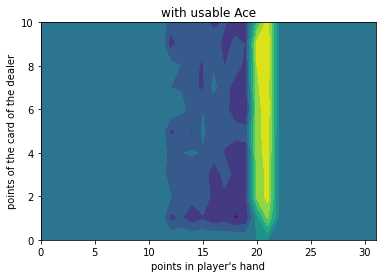

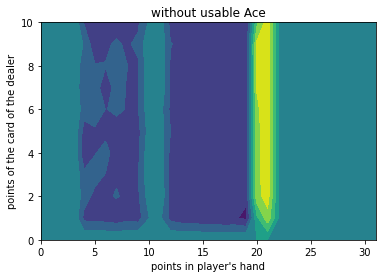

In [48]:
## Ours

x = np.arange(0,maxSum,1)
y = np.arange(0,maxOppScore,1)
# z1 for the states with usable ace
z1 = np.zeros((maxSum,maxOppScore))
# z2 for the states without usable ace
z2 = np.zeros((maxSum,maxOppScore))

v = policy_evaluation_all_visit(env, Niter=100000)

for i in range(maxSum):
  for j in range(maxOppScore):
    index = encode([i,j,True])
    z1[i,j] = v[index]
    index = encode([i,j,False])
    z2[i,j] = v[index]

xx, yy = np.meshgrid(x,y)
h = plt.contourf(x,y,z1[:,:].T)
plt.title("with usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
plt.show()
h = plt.contourf(x,y,z2[:,:].T)
plt.title("without usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
plt.show()

L'exemple du code ci-dessous permet de générer des graphiques en 3D pour visualiser la fonction $v$.

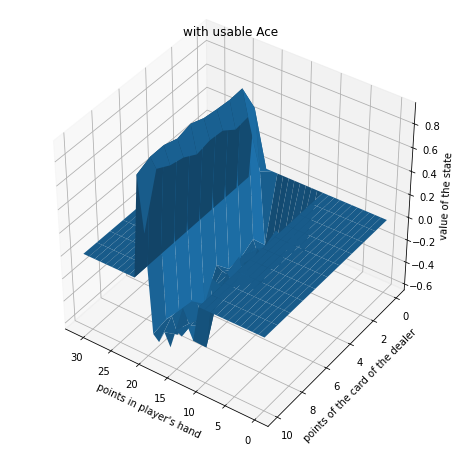

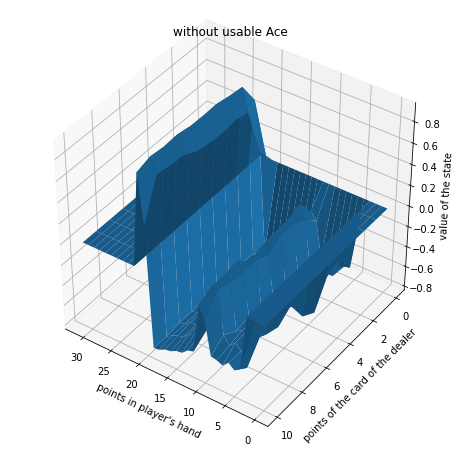

In [49]:
## Ours

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot_surface(xx,yy,z1[:,:].T)
ax.view_init(40,125)
plt.title("with usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
ax.set_zlabel("value of the state")
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot_surface(xx,yy,z2[:,:].T)
ax.view_init(40,125)
plt.title("without usable Ace")
plt.xlabel("points in player's hand")
plt.ylabel("points of the card of the dealer")
ax.set_zlabel("value of the state")
plt.show()

## Résolution : trouver une politique optimale

Avec les algorithmes "Value Iteration" ou "Policy Iteration", on aurait besoin de calculer la matrice de transition. Etant donné le nombre d'états, il serait probablement très fastidieux d'écrire cette matrice "à la main" ou bien d'écrire un programme pour calculer chaque probabilité exactement!



### Implémentez

Le but est d'implémenter l'algorithme Monte Carlo "on policy" pour trouver la politique optimale.

* Implémentez une fonction $draw(\pi)$ qui prend en paramètre une distribution de probabilités sur les actions et qui tire une action au hasard en utilisant cette distribution
* Implémentez une méthode $epsGreedy(\epsilon, q)$ qui implémente $\epsilon$-glouton: 
  * avec une probabilité $\epsilon$, la méthode choisie une action de manière uniforme
  * avec une probabilité $1-\epsilon$, ma méthode choisie l'action qui a la plus grande valeur $q$. Si plusieurs actions ont la même valeur maximale $\max_i q(i)$, il serait bon d'en choisir une au hasard (au lieu peut-être de choisir toujours la première action qui a pour valeur $\max_i q(i)$).
* implémentez une fonction $onPolicyMC(numEpisodes, \gamma, \epsilon)$ qui implémente l'algorithme on policy Monte Carlo qui résoud de manière optimale un PDM. Votre fonction peut retourner la valeur des paires (action, etat). Les paramètres d'entrée sont 
    * numEpisodes: le nombre d'épisodes utilisés pour apprendre la politique optimale
    * $\gamma$ est le taux d'escompte: on veut optimiser $\displaystyle G_t = \sum_{k=0}^\infty \gamma^k r_{t+k+1}$
    * $\epsilon$ est le paramètre pour utiliser $\epsilon$-greedy pour l'exploration
* Une fois que vous avez terminé, visualisez la politique trouvée (vous pouvez écrire dans un tableau si vous continuez ou vous vous arrêtez selon la valeur de la carte du croupier et selon la valeur de votre main (ou utiliser des couleurs). Est-ce que cette politique vous parait correcte? En comparant avec la politique étudiée plus haut, donne-t-elle des meilleures valeurs?

Notez qu'il serait bon d'avoir une implémentation qui puisse être générale de façon à pouvoir utiliser votre code pour d'autres environnement. En particulier dans le jeu de blackjack, on utilise $\gamma=1$, mais cela pourrait être différent pour d'autres environnement.

Si vous rencontrez des difficultés pour coder, vous pouvez dans un premier temps faire un code spécifique qui fait l'hypothèse que $\gamma=1$, voir même que vous recevez un récompense non nulle lorsque vous atteignez un état terminal. L'implémentation de ce cas est plus simple.

In [50]:
# on fait l'hypothèse que pi est un vecteur numpy de taille le nombre 
# d'actions disponible
def draw(pi):
    """Tire une action au hasard en utilisant la distribution pi"""
    a = list(range(len(pi))) # [0,1] dans notre cas
    return np.random.choice(a=a, p=pi)

# Helper function
def generate_episode(env, pi, max_timesteps=100):
    episode = []
    state = env.reset()
    #print(f'Initial state {state}')

    for t in range(max_timesteps):
        action = draw(pi[encode(state)]) # Choose action following policy pi
        new_state, reward, done, _ = env.step(action)
        #print(f'State {state}, action {action}, new state {new_state}, reward {reward}, done {done}')
        episode.append((state, action, reward))
        state = new_state
        if done:
            #print("Episode finished after {} timesteps".format(t+1))
            break
    #episode.append()
    return episode, len(episode)

In [51]:
import random

def eps_greedy(q, s, epsilon):
    
    p = np.random.rand()
    if p > epsilon:
        winner = np.argwhere(q[s] == np.amax(q[s]))
        winner = winner.flatten().tolist()
        action = np.random.choice(winner)
        #print(q[s], winner, action)
    else: 
        action = np.random.choice(numActions) 
    
    return action

def onPolicyMC(numEpisodes, epsilon=0.2, discount=1, verbose=False):
    """1st-visit version"""
    
    # Initialization
    q = np.zeros((numStates, numActions))
    count = np.zeros((numStates, numActions))
    acc = np.zeros((numStates, numActions))
    pi = np.ones((numStates, numActions))/2 # uniform policy
    
    visited = set()
    rewards = []
    episodes = [] # pour debug
    
    for i_episode in tqdm(range(numEpisodes)):
        
        episode = generate_episode(env, pi)
        episodes.append(episode)
        
        T = len(episode)
        G = 0 # G_T = 0
        
        for t in reversed(range(T)): # From T-1 to 0
            state, action, reward = episode[t]
            i_state = encode(state)
            #print(i_state)
            
            G = reward + discount*G # G_t
            
            if (state, action) not in visited:
                visited.add((state, action))
                acc[i_state, action] += G
                count[i_state, action] += 1
                q[i_state, action] = acc[i_state, action] / count[i_state, action]
                
                action_star = np.argmax(q[i_state])

                for a in range(numActions):
                    #print("iciii")
                    if a == action_star:
                        pi[i_state, a] = 1 - epsilon + epsilon/numActions
                    else:
                        pi[i_state, a] = epsilon/numActions 
                    
              
        rewards.append(G) # G_0 = total_reward
        
        if verbose and i_episode % 1000 == 0:
            print(f'=====> Episode {i_episode}, {T}, {G}')
        
    return q, rewards, episodes, pi

In [52]:
def on_policy_MC(env, num_episodes, num_states, gamma=1, epsilon=0.2, verbose=False):
    
     # Initialization
    q = np.zeros((num_states, env.action_space.n))
    #pi = defaultdict(lambda: 1/numActions)
    pi = np.ones((num_states, env.action_space.n))/env.action_space.n # uniform policy
    count = np.zeros((num_states, env.action_space.n))
    acc = np.zeros((num_states, env.action_space.n))
    
    #Returns = defaultdict(list) # dict of list
    rewards = []
    
    for i_episode in tqdm(range(num_episodes)):
        
        # Generate one episode
        episode, T = generate_episode(env, pi)
        
        if verbose:
            print(f'=====> Episode {i_episode}')
            print(episode, T)
        
        G = 0 # G_T
        for t in reversed(range(T)):
            St, At, Rt_1 = episode[t]
            St_encoded = encode(St) 
            #_, _, Rt_1 = episode[t+1]
            
            if verbose:
                print(f't={t}, St={St}, At={At}, Rt+1={Rt_1}')
            
            G = gamma*G + Rt_1
            
            if not (St, At) in [(episode[i][0], episode[i][1]) for i in range(0, t)]:
                
                #Returns[(St, At)].append(G)
                #q[St_encoded, At] = np.average(Returns[(St, At)])
                
                acc[St_encoded, At] += G
                count[St_encoded, At] += 1
                q[St_encoded, At] = acc[St_encoded, At] / count[St_encoded, At]
                
                if verbose:
                    print(f'{St_encoded}, q={q[St_encoded, At]}')
                action_star = np.argmax(q[St_encoded])
                
                for a in range(numActions):
                    if a == action_star:
                        pi[St_encoded,a] = 1 - epsilon + epsilon/numActions
                    else:
                        pi[St_encoded,a] = epsilon/numActions 
                        
        rewards.append(G) # G_0 = total_reward
        
    return q, rewards, pi

In [53]:
q, rewards, pi = on_policy_MC(env, num_states=numStates, num_episodes=100000, epsilon=0.1, verbose=False)

100%|██████████| 100000/100000 [00:18<00:00, 5314.86it/s]


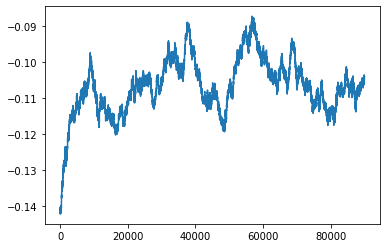

In [54]:
plt.plot(runningAvg(rewards, windowSize=10000))

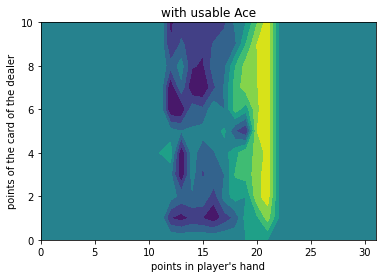

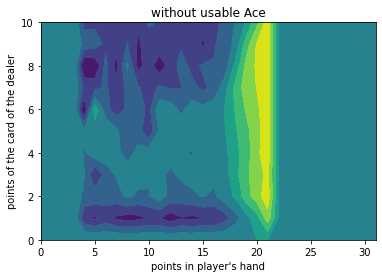

In [55]:
visualize_policy(q)

In [56]:
env = gym.make("Blackjack-v0")
episodes_reward, mean = exploitation(env, pi, num_episodes=1000)

=====> Episode 0


-0.313

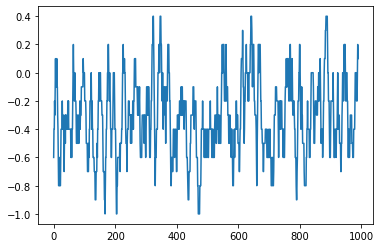

In [57]:
plt.plot(runningAvg(episodes_reward, windowSize=10))
mean

### Bonus
Vous pouvez tester votre code sur un autre environnement simple, par exemple frozen lake. Il existe plusieurs version de cet environnement, un avec une petite grille, un autre avec une grille plus grande.  On utilisera cet environnement dans le prochain TP.


In [58]:
env = gym.make("FrozenLake-v0")
numActions = env.action_space.n
print("there are ", numActions, "actions")
print("observation space: ", env.observation_space)
numStates = env.observation_space.n
print("there are ", numStates, "states")

there are  4 actions
observation space:  Discrete(16)
there are  16 states


In [59]:
s = env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


notez que dans cet environnement, les états sont simplement numérotés, on n'a donc plus besoin d'une fonction pour encoder ou décoder les états. 

In [60]:
def encode(state):
    return state

def decode(state):
    return state

In [70]:
env_f = env = gym.make("FrozenLake-v0")
q_f, rewards_f, pi_f = on_policy_MC(env_f, num_states=numStates, num_episodes=500000, epsilon=0.1, verbose=False)

100%|██████████| 500000/500000 [08:31<00:00, 976.92it/s]


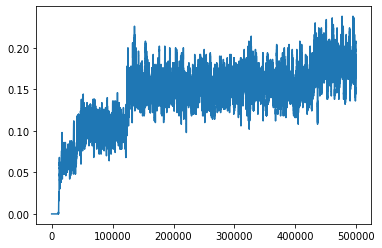

In [71]:
plt.plot(runningAvg(rewards_f, windowSize=500))

In [72]:
def plotQ(q_table, map_size):
    """Visualisation de la table Q pour FrozenLake 4x4 et 8x8.
    Passez la taille (4 ou 8) en paramètres
    """
    
    if(map_size == 4):
        MAP = [
            "SFFF",
            "FHFH",
            "FFFF",
            "HFFG"
        ]
    else:
        MAP=[
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG"
        ]
    best_value = np.max(q_table, axis=1).reshape((map_size, map_size))
    best_policy = np.argmax(q_table, axis=1).reshape((map_size, map_size))
    
    fig, ax = plt.subplots()
    im = ax.imshow(best_value)

    for i in range(best_value.shape[0]):
        for j in range(best_value.shape[1]):
            if MAP[i][j] in 'GH':
                arrow = MAP[i][j]
            elif best_policy[i, j] == 0:
                arrow = '<'
            elif best_policy[i, j] == 1:
                arrow = 'v'
            elif best_policy[i, j] == 2:
                arrow = '>'
            elif best_policy[i, j] == 3:
                arrow = '^'
            if MAP[i][j] in 'S':
                arrow = 'S ' + arrow
            text = ax.text(j, i, arrow, ha = "center", va = "center",
                         color = "black")
            
    cbar = ax.figure.colorbar(im, ax = ax)
    
    fig.tight_layout()
    plt.show()

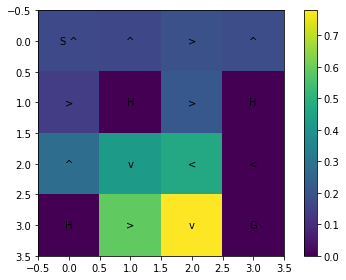

In [73]:
plotQ(q_f, 4)

=====> Episode 0
=====> Episode 1000
=====> Episode 2000
=====> Episode 3000
=====> Episode 4000


0.0258

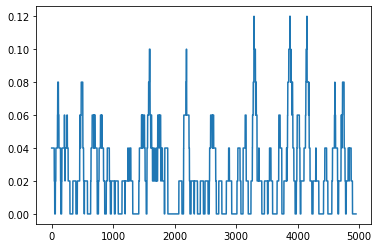

In [74]:
episodes_reward_f, mean_f = exploitation(env_f, pi_f, num_episodes=5000)
plt.plot(runningAvg(episodes_reward_f, windowSize=50))
mean_f